# This notebook is based on this blog from kaggle
# https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis

In [7]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
# Downloading stop words

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eugen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
dataset_filename = os.listdir("../input")[0]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ..\input\training.1600000.processed.noemoticon.csv


In [6]:
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
print("Dataset size:", len(df))
print(df.shape)

Dataset size: 1600000
(1600000, 6)


In [8]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 344 ms
Wall time: 833 ms


In [11]:
df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Dataset labels distribuition')

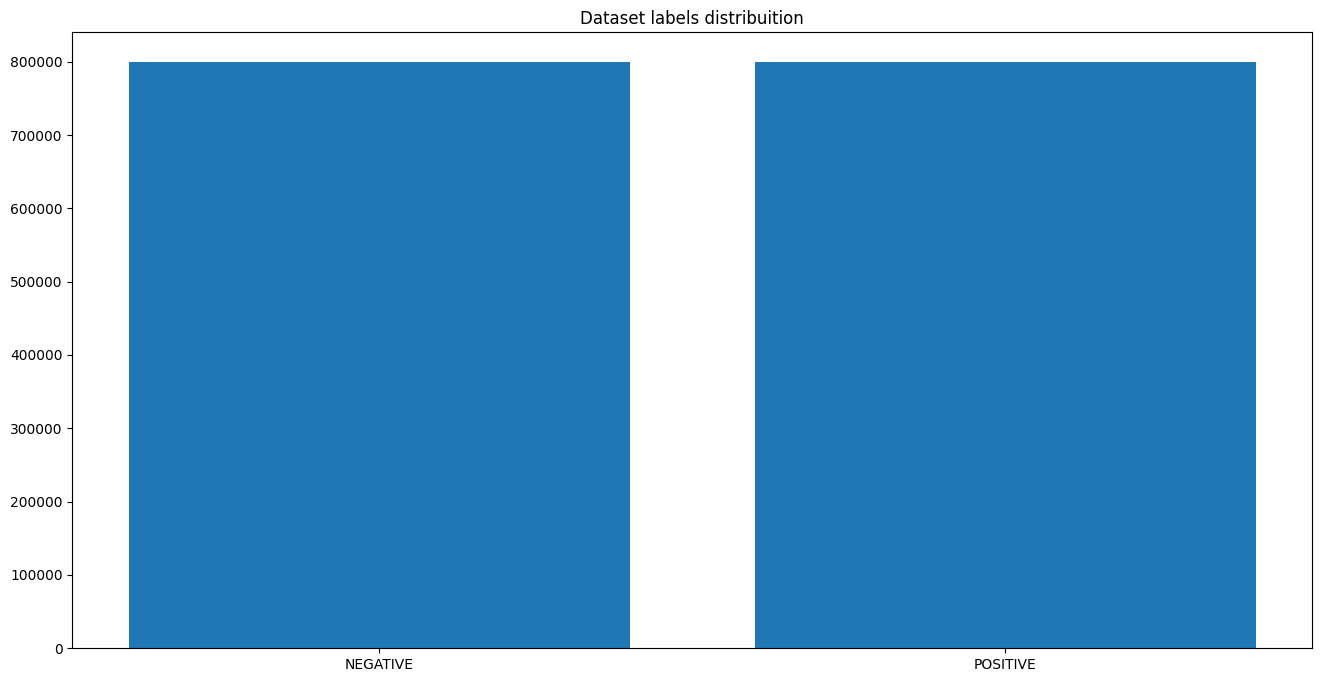

In [12]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Preprocessing

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [16]:
TEXT_CLEANING_RE

'@\\S+|https?:\\S+|http?:\\S|[^A-Za-z0-9]+'

In [24]:
type(df.text.iloc[0])

str

In [25]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [26]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 41.7 s
Wall time: 1min 55s


In [27]:
type(df.text.iloc[0])

str

In [29]:
df

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see
...,...,...,...,...,...,...
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feeling ever
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb com cool hear old walt interviews
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask details
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday boo alll time tupac amaru ...


## Split and train

In [30]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec

In [31]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 1.7 s
Wall time: 5.38 s


In [35]:
display(documents)
display(documents[0])

[['ya',
  'quot',
  'like',
  'palm',
  'pre',
  'touchstone',
  'charger',
  'readynow',
  'yes',
  'sounds',
  'good',
  'beer',
  'ready',
  'prelaunch'],
 ['felt', 'earthquake', 'afternoon', 'seems', 'epicenter'],
 ['ruffles', 'shirts', 'like', 'likey'],
 ['pretty',
  'bad',
  'night',
  'crappy',
  'morning',
  'fml',
  'buttface',
  'didnt',
  'say',
  'could',
  'go',
  'work',
  'today'],
 ['yeah', 'clear', 'view'],
 ['one',
  'time',
  'follow',
  'fam',
  'ff',
  'georgeann13',
  'nakithebeatman',
  'flimackgod',
  'chaz81',
  'djt',
  'elle',
  'jaejaedynomite',
  'welcome',
  'friday',
  'follow',
  '2'],
 ['u', 'rock', 'thanks', 'added', 'next', 'robcrotch', 'tm', 'video'],
 ['yes',
  'please',
  'met',
  'fiancee',
  'ian',
  'party',
  'day',
  'btw',
  'sweet',
  'congrats',
  'guys'],
 ['gawd',
  'finished',
  'whole',
  'bowl',
  'even',
  'posted',
  'previous',
  'tweet',
  'making',
  '2nd',
  'bowl'],
 ['awesome', 'game', 'short', 'finish', 'craving', 'god', 'war'

['ya',
 'quot',
 'like',
 'palm',
 'pre',
 'touchstone',
 'charger',
 'readynow',
 'yes',
 'sounds',
 'good',
 'beer',
 'ready',
 'prelaunch']

In [36]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [37]:
w2v_model.build_vocab(documents)

2023-06-13 11:14:37,379 : INFO : collecting all words and their counts
2023-06-13 11:14:37,383 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-06-13 11:14:37,461 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2023-06-13 11:14:37,547 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2023-06-13 11:14:37,619 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2023-06-13 11:14:37,692 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2023-06-13 11:14:37,769 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2023-06-13 11:14:37,823 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2023-06-13 11:14:37,882 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2023-06-13 11:14:37,941 : INFO : PROGRESS: at s

In [38]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [39]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-06-13 11:16:02,001 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2023-06-13 11:16:03,043 : INFO : EPOCH 1 - PROGRESS: at 8.25% examples, 675168 words/s, in_qsize 16, out_qsize 0
2023-06-13 11:16:04,061 : INFO : EPOCH 1 - PROGRESS: at 17.24% examples, 700222 words/s, in_qsize 13, out_qsize 2
2023-06-13 11:16:05,079 : INFO : EPOCH 1 - PROGRESS: at 26.56% examples, 718591 words/s, in_qsize 16, out_qsize 0
2023-06-13 11:16:06,093 : INFO : EPOCH 1 - PROGRESS: at 35.65% examples, 723470 words/s, in_qsize 16, out_qsize 0
2023-06-13 11:16:07,110 : INFO : EPOCH 1 - PROGRESS: at 44.94% examples, 729074 words/s, in_qsize 16, out_qsize 1
2023-06-13 11:16:08,112 : INFO : EPOCH 1 - PROGRESS: at 53.92% examples, 730740 words/s, in_qsize 15, out_qsize 0
2023-06-13 11:16:09,123 : INFO : EPOCH 1 - PROGRESS: at 62.46% examples, 725858 words/s, in_qsize 16, out_qsize 1
2023-06-13 11:16:10,126 : INFO : EPOCH 1 - PROGRESS: 

CPU times: total: 10min 7s
Wall time: 5min 40s


(263132430, 295270528)

In [40]:
w2v_model.most_similar("love")

C:\Users\eugen\AppData\Local\Temp\ipykernel_32876\2564826958.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("love")
2023-06-13 11:35:56,154 : INFO : precomputing L2-norms of word weight vectors


[('loves', 0.5732482671737671),
 ('luv', 0.5623058080673218),
 ('loved', 0.5296382904052734),
 ('adore', 0.516393780708313),
 ('amazing', 0.5132331848144531),
 ('looove', 0.49213874340057373),
 ('awesome', 0.4595926105976105),
 ('lovee', 0.45821839570999146),
 ('loveee', 0.44987452030181885),
 ('miss', 0.44771474599838257)]

### Tokenize text

In [43]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: total: 14.1 s
Wall time: 14.8 s


In [42]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 12.2 s
Wall time: 50.2 s


### Label Encoder

In [44]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [45]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [46]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [47]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [48]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [49]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Building a model

In [50]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [51]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [52]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=1,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Create prediction

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [1]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

### Confusion matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Final result

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

## Loading model

In [7]:

# Fixing the copy_reg issue by converting the \r to ]n (difference between Linux and Windows)
# with open('tokenizer.pkl','rb') as f:
#     lines=f.readlines()
#     lines=[str(x, encoding="utf-8").replace('\r\n','\n') for x in lines]
#     lines=[ bytes(x, encoding="utf8") for x in lines]

# with open('tokenizer_upd.pkl','wb') as nf:
#     for line in lines:
#         nf.write(line)

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, load_model # Add 'load_model'
from joblib import dump, load # For reading the Tokenizer Pickle
from pathlib import Path
import os
import time

# Loading current path's parent to locate output files
cwd = Path.cwd().parent
model_h5_path = os.path.join(cwd, 'output\\model.h5')
tokenizer_pkl_path = os.path.join(cwd, 'output\\tokenizer_upd.pkl')


KERAS_MODEL = model_h5_path
TOKENIZER_MODEL = 'tokenizer_upd.pkl'#tokenizer_pkl_path

# KERAS
SEQUENCE_LENGTH = 300

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# Load the model and the tokenizer to make predictions
model = load_model(KERAS_MODEL)
tokenizer = load(TOKENIZER_MODEL)

FileNotFoundError: [Errno 2] No such file or directory: 'tokenizer_upd.pkl'

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [22]:
predict("I hate the music")

1/1 [==============================] - 0s 305ms/step


{'label': 'NEGATIVE',
 'score': 0.059747807681560516,
 'elapsed_time': 0.3576171398162842}